<font color='red'>**Important**: </font> If the kernel doesn't attach automatically or you need to restart the kernel, please choose 'conda_python3' kernel. 

# How to find an infrastructure or company in a set of images with text?

We have built a smart cloud solution to automatically extract metadata from the images. 

In this quest, we are going to extract various type of information from the images to facilitate finding companies or infrastructures and then with the Google Earth Engine match it to the exact directions. To accomplish this goal, we are going to leverage AWS image (Amazon Rekogntion) and Natural Language Processing (Amazon Comprehend) AI services. These managed AI services make advanced machine learning accessible without the need to train any new model.

we have uploaded about 100 images to an S3 bucket. The images are also copied to this instance at: /home/ec2-user/SageMaker/images/

Run each block of code one by one either by clicking on "Run" on the menu above or by pressing SHIFT+ENTER on your keyboard. 

## Setup: Importing Python Packages

In [3]:
!pip install boto3

     |████████████████████████████████| 131 kB 8.7 MB/s 
     |████████████████████████████████| 8.0 MB 49.3 MB/s 
     |████████████████████████████████| 79 kB 10.6 MB/s 
     |████████████████████████████████| 138 kB 74.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.7 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
import boto3
import pandas as pd
import os
import uuid
import matplotlib.pyplot as plt
import random
from matplotlib.pylab import imread, imshow
from PIL import Image

In [5]:
LOCAL_PATH = '/home/ec2-user/SageMaker/'
LOCAL_IMAGE_PATH = '/home/ec2-user/SageMaker/images/'

### Complete the information below
In the AWS console, find S3 and click on it, select the one with 'readimages' in the name. Open the bucket by clicking on it to make sure images are there. Copy the name of the bucket and supply it to "BUCKET_NAME" variable below.
Go to AWS console (by clicking on AWS logo on top left) and find you region code from the drop-down menu on top right of the screen. Look at the highlighted region on the list and copy the region code (for example: us-east-1 or eu-west-2) which is listed next to the region name. Copy the region code and supply it to "REGION" variable below as a string. Please note you need to copy the region code (like ‘us-east-1’) and not the region name (like US East (N. Virginia))! 

In [6]:
# Name of the S3 bucket containing images which should start with jam-readimage. Go to S3 console to find them name
# Name of the region you are in. Go to AWS console and find you region code from the drop down icon on top right 
# of the screen. For example us-east-1 or eu-west-2
BUCKET_NAME = 'labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readimages-y0uo5w20htc'
REGION = 'ap-southeast-2'

In [7]:
def submit_your_answer(results_df, task_file_name, task_answer):
    '''Upload your response to S3 in json format. This acts as your submission!
       Arguments:
           results_df (Dataframe): Master Pandas dataframe holding your results
           task_file_name (str): name of the task file you are submitting 
           task_answer (str): your response to the task ('xxx.jpg')
    '''    
    results_df.loc[task_answer].to_json(os.path.join(LOCAL_PATH, task_file_name))
    s3 = boto3.client('s3')
    s3.upload_file(Bucket=BUCKET_NAME, Filename=os.path.join(LOCAL_PATH, task_file_name), Key=task_file_name)


In [8]:
def plot_image(image_key, image_title=''):
    '''Plots an image
       Arguments:
           image_key (str): image file name
           image_title (str): Title of the image
    '''        
    plt.figure(figsize=(12, 10))
    image = imread(os.path.join(LOCAL_IMAGE_PATH, image_key))
    plt.imshow(image)
    plt.axis('off')
    plt.title('{}: {}'.format(image_key, image_title))
    plt.show()    

### Get the list of images stored in S3

In [10]:
s3 = boto3.client('s3')
image_keys = []
resp = s3.list_objects_v2(Bucket=BUCKET_NAME)
for obj in resp['Contents']:
    if obj['Key'][-4:] == '.jpg':
        image_keys.append(obj['Key'])
print('Number of images: {}'.format(len(image_keys)))

NoCredentialsError: ignored

### Create a Pandas dataframe for the results
Create a place holder for the results of this challenge. In each task, you will populate a one or more columns of this dataframe.

In [ ]:
cols = ['bucket_name',
        'image_key',
        'text_in_image',
        'dominant_language_code',
        'dominant_language_score',
        'sentiment',
        'sentiment_positive_score', 
        'sentiment_negative_score', 
        'sentiment_neutral_score', 
        'sentiment_mixed_score',
        'n_faces',
        'label',
        'label_conf']

results_df = pd.DataFrame(index=image_keys, columns=cols)
results_df['bucket_name'] = BUCKET_NAME
results_df['image_key'] = image_keys

In [ ]:
results_df.head()

bucket_name image_key  \
100.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   100.jpg   
101.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   101.jpg   
102.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   102.jpg   
103.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   103.jpg   
104.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   104.jpg   

        text_in_image dominant_language_code dominant_language_score  \
100.jpg           NaN                    NaN                     NaN   
101.jpg           NaN                    NaN                     NaN   
102.jpg           NaN                    NaN                     NaN   
103.jpg           NaN                    NaN                     NaN   
104.jpg           NaN                    NaN                     NaN   

        sentiment sentiment_positive_score sentiment_negative_score  \
100.jpg       NaN                      NaN                      NaN   
101.jpg       NaN                      NaN                      NaN   
102.jpg       NaN                      NaN                      NaN   
103.jpg       NaN                      NaN                      NaN   
104.jpg       NaN                      NaN                      NaN   

        sentiment_neutral_score sentiment_mixed_score n_faces label label_conf  
100.jpg                     NaN                   NaN     NaN   NaN        NaN  
101.jpg                     NaN                   NaN     NaN   NaN        NaN  
102.jpg                     NaN                   NaN     NaN   NaN        NaN  
103.jpg                     NaN                   NaN     NaN   NaN        NaN  
104.jpg                     NaN                   NaN     NaN   NaN        NaN

## Let's look at a sample of images
The following code snippet, displays 10 random. You can run it couple of times to get a sense of images in the archive.

In [ ]:
def display_images(image_keys, n_row=5, n_col=2):
    '''Display sample of images stored locally
       Arguments:
           image_keys (list): List of image keys 
           n_row (int): Number of rows in the image display
           n_col (int): Number of columns in the image display
    '''
    n_sample_images = n_row * n_col
    figure, ax = plt.subplots(nrows=n_row, ncols=n_col)
    figure.set_size_inches(10, 12)
    for ind in range(n_sample_images):
        ii = random.randrange(len(image_keys))
        image = imread(os.path.join(LOCAL_IMAGE_PATH, image_keys[ii]))
        ax.ravel()[ind].imshow(image)
        ax.ravel()[ind].set_axis_off()
        ax.ravel()[ind].set_title(image_keys[ii])

    plt.tight_layout()
    plt.show()


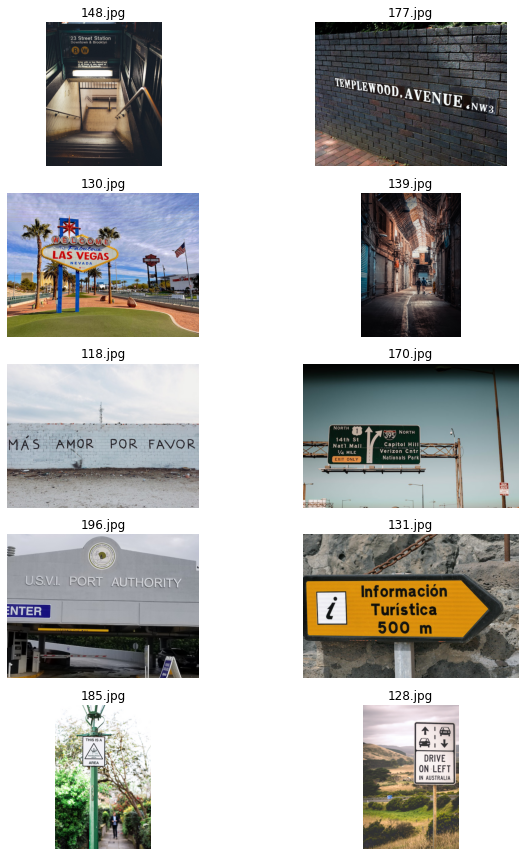

In [ ]:
display_images(image_keys, n_row=5, n_col=2)

## <font color='8B008B'> Task 1: Read Text in the Images</font>

As an example let us assume we are looking for the National Mall or Temple in Washington, USA, that holds the unique Lincoln Memorial. In this first, we are going to extract text from images stored in S3 using Amazon Rekognition 'detect_text' API. Please note that Task \#2 and Task \#3 depend on Task \#1. 
More information on Amazon Rekognition 'detect_text' API:
https://docs.aws.amazon.com/rekognition/latest/dg/text-detecting-text-procedure.html
To complete this task, you need to:

### Step #1: 
Run the "extract_text_from_image" function.

### Step #2:
Run the "extract_text_from_image" function you just completed on all the images. 

### Step #3: 
Find the image containing the term "Lincoln" (case insensitive). To do that we can iterate over the of the "results_df" dataframe" and check if the term "Lincoln" exist in the "text_in_image" field (code written for you). Your response should be a string in the form of 'xxx.jpg'. 

Run 'upload_answer_to_s3' line to upload you answer as json to S3. You are done! You'll receive credit in few minutes if your answer is correct. Remember, you have to complete Step #1 and Step #2 before Step #3 or you will not get credit!

### Task 1 Step 1: Extract text from Image
The "extract_text_from_image" function returns text in an image stored in S3 by using Amazon Rekognition 'detect_text' API. Remember, you need to extract text tokens from the response returned by Rekognition and then join them by a single space (included in the code). The function should return a string containing all the text lines found in the image joined by single spaces. 

Please note that the API response from Amazon Rekognition is a Python dictionary. It detects both "LINE" and "WORD" in the image which are linked together using a "ParentID" field for the "WORDS" tokens. So, in order to extract and combine text from the json response, you just need to first extract a list of tokens with "Type: LINE" (text_tokens) and then join them with a space. Just iterating over response['TextDetections'] and checking, if the item['Type'] == 'LINE'. If yes, token['DetectedText'] gives the text in that line. Then joining all of these line tokens with a space as shown in the code. The final extract text should be in lower case (already implemented in the return).

In [ ]:
def extract_text_from_image(bucket_name, image_key):
    '''Extracts text from an image by calling Amazon Rekognition detect_text API
       Arguments:
           bucketName (str): Name of the S3 bucket containing images
           image_key (str): object key of the image
       Output:
           text (str): Space joined text lines found on the image       
    '''

    rekognition = boto3.client('rekognition', region_name=REGION)
    response = rekognition.detect_text(
    Image={
        'S3Object': {
            'Bucket': bucket_name,
            'Name': image_key
        }
    }
)
    detected_text = response['TextDetections']
    text_tokens = [token['DetectedText'].lower() for token in detected_text if token['Type'] == 'LINE']
    text = ' '.join(text_tokens) 
    return(text)
    

### Sample test for the "extract_text_from_image" function (extracted text is in the title)

Automatically extracted text: may earth on prevail peace


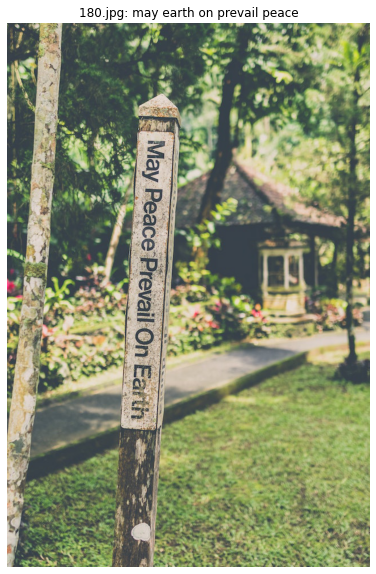

In [ ]:
# Sample test for the May Peace Prevail on Earth hotel chain for the "extract_text_from_image" function. Extracted text is in the title
sample_image = '180.jpg'
text = extract_text_from_image(BUCKET_NAME, sample_image)
print('Automatically extracted text: {}'.format(text))
plot_image(sample_image, image_title=text)


### Task 1 Step 2: Populate 'text_in_image' column of the dataframe
Run the following block once you completed "extract_text_from_image". It will extract text from all images stored in S3 and populates the 'text_in_image' column of the results_df. Please makes sure the "extract_text_from_image" function in Step #1 works as expected since this step can take a few minutes to complete and you don't want to repeat it.

In [ ]:
for i, (key, row) in enumerate(results_df.iterrows()):
    print('processing image: {}'.format(key))

    # Extract text in the image
    text_in_image = extract_text_from_image(BUCKET_NAME, key)
    results_df.loc[key, 'text_in_image'] = text_in_image

processing image: 100.jpg
processing image: 101.jpg
processing image: 102.jpg
processing image: 103.jpg
processing image: 104.jpg
processing image: 105.jpg
processing image: 106.jpg
processing image: 107.jpg
processing image: 108.jpg
processing image: 109.jpg
processing image: 110.jpg
processing image: 111.jpg
processing image: 112.jpg
processing image: 117.jpg
processing image: 118.jpg
processing image: 119.jpg
processing image: 122.jpg
processing image: 123.jpg
processing image: 124.jpg
processing image: 125.jpg
processing image: 126.jpg
processing image: 127.jpg
processing image: 128.jpg
processing image: 129.jpg
processing image: 130.jpg
processing image: 131.jpg
processing image: 132.jpg
processing image: 133.jpg
processing image: 134.jpg
processing image: 135.jpg
processing image: 136.jpg
processing image: 137.jpg
processing image: 138.jpg
processing image: 139.jpg
processing image: 141.jpg
processing image: 143.jpg
processing image: 144.jpg
processing image: 145.jpg
processing i

###  Task 1 Step 3: Find the image containing the word 'Lincoln' and submit your answer 
Based on the 'text_in_image' column of the results_df, which image has the word "Lincoln" (case insensitive) or optionally the whole unique phrase dedicated to him and his lecagy in it?

In [ ]:
for index, row in results_df.iterrows():
    if 'lincoln' in row['text_in_image'].lower():
        print(index)

157.jpg


Do you see any images containing the word "Lincoln"? Let's also plot to make sure this is the correct answer! Afterwards the coordinates of the building can be retrieved with our Google Earth Engine developer access and there matched to the exact direction and street with Google Maps.

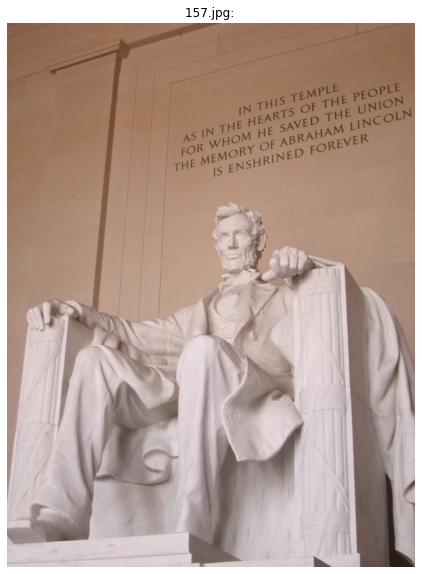

In [ ]:
task1_answer = '157.jpg'### ANSWER IN THE FORM of 'xxx.jpg'
plot_image(task1_answer, image_title='')

##################################################################################################################
### SUBMISSION (DON'T CHANGE THE CODE)
Run the following cell which turns one row of the "results_df" corresponding to your answer into json and uploads it to S3. <font color='red'> **DON'T CHANGE THIS LINE** </font>. Just run it as it is once you have your answer in 'task1_answer'. 
##################################################################################################################

In [ ]:
# DON'T CHANGE THIS LINE OR YOUR SUBMISSION FAILS
submit_your_answer(results_df, 'task1_res.json', task1_answer)

## <font color='8B008B'> Task 2: Detect Dominant Language in Text </font>

If we want to scale this solution globally and multilingually, some of the satelite, airplane, drone or Streetview images contain languages other than English. It is important to know which ones, as it impacts image selection. It is possible to detect the dominant language automatically.

The first task is to find dominant language in the text of all images. Out of all images containing German text (not all images),
which one has the highest dominant language confidence score. To do this, we are going to leverage detect_dominant_language API of
Amazon Comprehend AI service. More about the 'detect_dominant_language' API:

https://docs.aws.amazon.com/comprehend/latest/dg/get-started-api-dominant-language.html

Boto3 Amazon Comprehend API 'detect_dominant_language' reference:

https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/comprehend.html#Comprehend.Client.detect_dominant_language

### Step #1:
Complete "extract_dominant_language" function

### Step #2:
Run the "extract_dominant_language" function you just completed on the text of all the images. 

### Step #3: 
Find the image with highest confidence score among those containing German text and submit your answer 

### Task 2 Step 1- Detect Dominant Language
Complete "extract_dominant_language" function: This function uses Amazon Comprehend detect_dominant_language API to detect the dominant language in the text. Once you receive raw response from Amazon Comprehend, analyze it to see where you can find dominant language code and dominant language score. 
Return both the dominant language code and the dominant language score (detection confidence). The portion of the function you write shouldn't be more than a few lines of code.

In [ ]:
def extract_dominant_language(text):
    '''Extracts dominant language by calling Amazon Comprehend 'detect_dominant_language' API
       Arguments:
           text (str): Text to be analyzed 
       Output:
           dominant_language_code (str): Deteceted dominant language code       
           dominant_language_score (float): Score that indicates the confidence level on detected dominant language
    '''
    ### Your code (less than 5 lines of code)
    # Call the API first

    comprehend = boto3.client(service_name='comprehend', region_name='ap-southeast-2')
    
    text2=comprehend.detect_dominant_language(Text = text)["Languages"]
    
    dominant_language_code = text2[0]["LanguageCode"] #Extract from API response
    dominant_language_score = text2[0]["Score"]  # Extract from API response
    return dominant_language_code, dominant_language_score

In [ ]:
# Sample test for the "extract_dominant_language" function
extract_dominant_language('I am learning AWS AI services')

('en', 0.9271045327186584)

### Task 2 Step 2: Populate 'dominant_language_code' and 'dominant_language_score' columns of the dataframe
Run the following cell once you completed "extract_dominant_language". It is going to extract dominant language and confidence score from 'text_in_image' column of 'results_df' and fill the 'dominant_language_code' and 'dominant_language_score' columns. You don't need to do anything (no coding) other than running the code block under Task 2 Step 2 subsection. Please makes sure the "extract_dominant_language" function in Step #1 works as expected before running this step. After it is done, take a look at "results_df" dataframe to make sure the 'dominant_language_code' and 'dominant_language_score' are populated. Other columns should be empty at this point. Note that in some cases it is not possible to extract the dominant language (maybe not enough text). 

In [ ]:
for i, (key, row) in enumerate(results_df.iterrows()):
    print('processing image: {}'.format(key))

    # Extract text from results_df
    text_in_image = row['text_in_image']
    results_df.loc[key, 'text_in_image'] = text_in_image
    try: 
        dominant_language_code, dominant_language_score = extract_dominant_language(text_in_image)
        results_df.loc[key, 'dominant_language_code'] = dominant_language_code
        results_df.loc[key, 'dominant_language_score'] = round(dominant_language_score, 2)
    except:
        print('dominant language extraction  failed')
        pass

processing image: 100.jpg
processing image: 101.jpg
processing image: 102.jpg
processing image: 103.jpg
processing image: 104.jpg
processing image: 105.jpg
processing image: 106.jpg
processing image: 107.jpg
processing image: 108.jpg
processing image: 109.jpg
processing image: 110.jpg
processing image: 111.jpg
processing image: 112.jpg
processing image: 117.jpg
dominant language extraction  failed
processing image: 118.jpg
processing image: 119.jpg
dominant language extraction  failed
processing image: 122.jpg
processing image: 123.jpg
processing image: 124.jpg
processing image: 125.jpg
processing image: 126.jpg
processing image: 127.jpg
processing image: 128.jpg
processing image: 129.jpg
processing image: 130.jpg
processing image: 131.jpg
processing image: 132.jpg
processing image: 133.jpg
processing image: 134.jpg
processing image: 135.jpg
processing image: 136.jpg
processing image: 137.jpg
processing image: 138.jpg
dominant language extraction  failed
processing image: 139.jpg
domin

In [ ]:
results_df.head()

bucket_name image_key  \
100.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   100.jpg   
101.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   101.jpg   
102.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   102.jpg   
103.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   103.jpg   
104.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   104.jpg   

                                             text_in_image  \
100.jpg  aux herds of larmee d'orient et des terres loi...   
101.jpg                                               home   
102.jpg                                  you are beautiful   
103.jpg                    all are welcome here. consentle   
104.jpg  @@@@@@@@@@? work hard stay humble $ m w 1 f no...   

        dominant_language_code dominant_language_score sentiment  \
100.jpg                     fr                    0.51       NaN   
101.jpg                     en                       1       NaN   
102.jpg                     en                       1       NaN   
103.jpg                     en                       1       NaN   
104.jpg                     en                    0.86       NaN   

        sentiment_positive_score sentiment_negative_score  \
100.jpg                      NaN                      NaN   
101.jpg                      NaN                      NaN   
102.jpg                      NaN                      NaN   
103.jpg                      NaN                      NaN   
104.jpg                      NaN                      NaN   

        sentiment_neutral_score sentiment_mixed_score n_faces label label_conf  
100.jpg                     NaN                   NaN     NaN   NaN        NaN  
101.jpg                     NaN                   NaN     NaN   NaN        NaN  
102.jpg                     NaN                   NaN     NaN   NaN        NaN  
103.jpg                     NaN                   NaN     NaN   NaN        NaN  
104.jpg                     NaN                   NaN     NaN   NaN        NaN

### Task 2 Step 3: Find the image with highest confidence score among those containing German text

Out of all images with German text (language code: 'de'), which one has the highest 'dominant_language_score'? Code is provided to filter "results_df" to rows with German text.
You can then either use the 'index' or the 'image_key' column to extract the image file name. 

Run 'upload_answer_to_s3' line to upload you answer as json to S3. 

In [ ]:
results_df[results_df.dominant_language_code=='de']

bucket_name image_key  \
110.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   110.jpg   
134.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   134.jpg   
151.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   151.jpg   
188.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   188.jpg   

                                             text_in_image  \
110.jpg  widerrechtlich abgestellte fahrzeuge werden ko...   
134.jpg                                             notruf   
151.jpg                                8128810 fa 15845963   
188.jpg                                          kreuzberg   

        dominant_language_code dominant_language_score sentiment  \
110.jpg                     de                       1       NaN   
134.jpg                     de                    0.74       NaN   
151.jpg                     de                    0.53       NaN   
188.jpg                     de                    0.75       NaN   

        sentiment_positive_score sentiment_negative_score  \
110.jpg                      NaN                      NaN   
134.jpg                      NaN                      NaN   
151.jpg                      NaN                      NaN   
188.jpg                      NaN                      NaN   

        sentiment_neutral_score sentiment_mixed_score n_faces label label_conf  
110.jpg                     NaN                   NaN     NaN   NaN        NaN  
134.jpg                     NaN                   NaN     NaN   NaN        NaN  
151.jpg                     NaN                   NaN     NaN   NaN        NaN  
188.jpg                     NaN                   NaN     NaN   NaN        NaN

Did you find it? If yes, provide the 'task2_answer' variable below with the image name ('xxx.jpg'). Let's also plot to make sure this is the correct answer!

Text: widerrechtlich abgestellte fahrzeuge werden kostenpflichtig abgeschleppt
Dominant Language: de
Dominant Language Confidence: 1.0


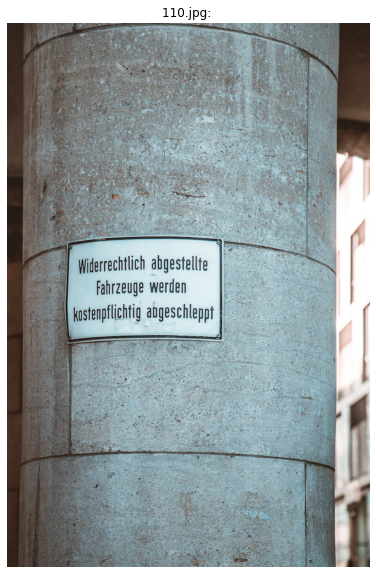

In [ ]:
task2_answer = '110.jpg'
print('Text: {}'.format(results_df.loc[task2_answer, 'text_in_image']))
print('Dominant Language: {}'.format(results_df.loc[task2_answer, 'dominant_language_code']))
print('Dominant Language Confidence: {}'.format(results_df.loc[task2_answer, 'dominant_language_score']))
plot_image(task2_answer, image_title='')

##################################################################################################################
### SUBMISSION (DON'T CHANGE THE CODE)
Run the following cell which turns one row of the "results_df" corresponding to your answer into json and uploads it to S3. <font color='red'> **DON'T CHANGE THIS LINE** </font>. Just run it as it is once you have your answer in 'task2_answer'. 
##################################################################################################################

In [ ]:
# DON'T CHANGE THIS LINE OR YOUR SUBMISSION FAILS
submit_your_answer(results_df, 'task2_res.json', task2_answer)

## <font color='8B008B'> Task 3: Example of further NLP Analysis for identification: Sentiment Analysis </font>

You wonder if you can do automated sentiment analysis and further enrich the image metadata. To do this, you are going to leverage 'detect_sentiment' API of Amazon Comprehend AI service. More about the 'detect_sentiment' API:

https://docs.aws.amazon.com/comprehend/latest/dg/how-sentiment.html 

Amazon Comprehend API 'detect_sentiment' reference:

https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/comprehend.html#Comprehend.Client.detect_sentiment

Your task is extract sentiment and associated scores from text found on each of the images, and
find the image with most negative sentiment among those with English text.

### Step #1:
Complete 'sentiment_detection' function.

### Step #2:
Run the 'sentiment_detection' function on the text of all images.

### Step #3: 
Finding the image containing most negative English text and submitting the answer.


### Task 3 Step 1- Sentiment Analysis
Complete 'sentiment_detection' function: This function uses Amazon Comprehend 'detect_sentiment' API to extract text sentiment. Extract both the sentiment and sentiment_scores for each of the [POSITIVE | NEGATIVE | NEUTRAL | MIXED] sentiment possibilities. The portion of the function you write shouldn't be more than a few lines of code. First call Amazon Comprehend 'detect_sentiment' and get a raw response. Analyze the response and make see how you can extract both sentiment and sentiment score. sentiment_score is going to be a Python dictionary. This can be done in 5 lines of code!

In [ ]:
def sentiment_detection(text, language_code):
    '''Extracts sentiment of the text using Amazon Comprehend 
       Arguments:
           text (str): Text to be analyzed 
           language_code (str): 2-letter language code of the text to be analyzed (e.g. "en")
       Output:
           sentiment (str): One the [POSITIVE | NEGATIVE | NEUTRAL | MIXED] returned by Amazon Comprehend    
           sentiment_scores (dict): Confidence that Amazon Comprehend has in the accuracy of its detection 
           of the each of the above sentiments. A dictionary with the following keys [POSITIVE, NEGATIVE, NEUTRAL, MIXED].
           sample:
               sentiment_scores: {
                                    "Mixed": 0.0033542951568961143,
                                    "Positive": 0.9869875907897949,
                                    "Neutral": 0.008563132025301456,
                                    "Negative": 0.0010949420975521207
                                }
    '''
    ### less than 5 lines of code
    # Call the API first
    
    comprehend = boto3.client(service_name='comprehend', region_name='ap-southeast-2')
                   
    text3=comprehend.detect_sentiment(Text=text, LanguageCode='en')
    sentiment = text3["Sentiment"]#Extract from API response
    sentiment_scores = text3["SentimentScore"]# Extract from API response (a Python Dictionary)
    return sentiment, sentiment_scores


In [ ]:
## Sample test for your function
sentiment_detection('Today is a fantastic day', 'en')

('POSITIVE',
 {'Positive': 0.9974599480628967,
  'Negative': 0.00018005631864070892,
  'Neutral': 0.0019463356584310532,
  'Mixed': 0.0004137237265240401})

## Task 3 Step 2: Populate 'sentiment' and 'sentiment_score' columns of the dataframe
Let's run the 'sentiment_detection' function on the text of all images. It is going to extract sentiment and see sentiment scores from 'text_in_image' column of 'results_df' and fill the 'sentiment' and four 'sentiment_score' columns. You don't need to do anything (no coding) other than running the code block under Task 3 Step 2 subsection. Please makes sure the "sentiment_detection" function in Step #1 works as expected before running this step. After it is done, take a look at "results_df" dataframe to make sure the 'sentiment' and four 'sentiment_score' are populated. Other columns should be empty at this point. Note that in some cases it is not possible to extract the sentiment (maybe not enough text) so it fails (and it is OK!). Don't worry if you see those cases!

In [ ]:
for i, (key, row) in enumerate(results_df.iterrows()):
    print('processing image: {}'.format(key))

    # Extract text from results_df
    text_in_image = row['text_in_image']
    try: 
        sentiment, sentiment_scores = sentiment_detection(text_in_image, row['dominant_language_code'])
        results_df.loc[key, 'sentiment'] = sentiment
        results_df.loc[key, 'sentiment_positive_score'] = round(sentiment_scores['Positive'], 2)
        results_df.loc[key, 'sentiment_negative_score'] = round(sentiment_scores['Negative'], 2)
        results_df.loc[key, 'sentiment_neutral_score'] = round(sentiment_scores['Neutral'], 2)
        results_df.loc[key, 'sentiment_mixed_score'] = round(sentiment_scores['Mixed'], 2)
    except:
        print('sentiment analysis failed')
        pass

processing image: 100.jpg
processing image: 101.jpg
processing image: 102.jpg
processing image: 103.jpg
processing image: 104.jpg
processing image: 105.jpg
processing image: 106.jpg
processing image: 107.jpg
processing image: 108.jpg
processing image: 109.jpg
processing image: 110.jpg
processing image: 111.jpg
processing image: 112.jpg
processing image: 117.jpg
sentiment analysis failed
processing image: 118.jpg
processing image: 119.jpg
sentiment analysis failed
processing image: 122.jpg
processing image: 123.jpg
processing image: 124.jpg
processing image: 125.jpg
processing image: 126.jpg
processing image: 127.jpg
processing image: 128.jpg
processing image: 129.jpg
processing image: 130.jpg
processing image: 131.jpg
processing image: 132.jpg
processing image: 133.jpg
processing image: 134.jpg
processing image: 135.jpg
processing image: 136.jpg
processing image: 137.jpg
processing image: 138.jpg
sentiment analysis failed
processing image: 139.jpg
sentiment analysis failed
processing i

In [ ]:
results_df.head()

bucket_name image_key  \
100.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   100.jpg   
101.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   101.jpg   
102.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   102.jpg   
103.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   103.jpg   
104.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   104.jpg   

                                             text_in_image  \
100.jpg  aux herds of larmee d'orient et des terres loi...   
101.jpg                                               home   
102.jpg                                  you are beautiful   
103.jpg                    all are welcome here. consentle   
104.jpg  @@@@@@@@@@? work hard stay humble $ m w 1 f no...   

        dominant_language_code dominant_language_score sentiment  \
100.jpg                     fr                    0.51   NEUTRAL   
101.jpg                     en                       1   NEUTRAL   
102.jpg                     en                       1  POSITIVE   
103.jpg                     en                       1   NEUTRAL   
104.jpg                     en                    0.86   NEUTRAL   

        sentiment_positive_score sentiment_negative_score  \
100.jpg                        0                        0   
101.jpg                     0.01                     0.01   
102.jpg                     0.99                        0   
103.jpg                     0.35                     0.02   
104.jpg                     0.01                        0   

        sentiment_neutral_score sentiment_mixed_score n_faces label label_conf  
100.jpg                    0.99                     0     NaN   NaN        NaN  
101.jpg                    0.97                     0     NaN   NaN        NaN  
102.jpg                       0                     0     NaN   NaN        NaN  
103.jpg                     0.5                  0.13     NaN   NaN        NaN  
104.jpg                    0.99                     0     NaN   NaN        NaN

### Task 3 Step 3: Find the image with the most negative english text in it! 
Based on the 'sentiment_negative_score' and 'dominant_language_code' column of the results_df, which image has the most negative English text sentiment in it? Code is provided to sort the dataframe by 'sentiment_negative_score' in descending order. Can then either use the 'index' or the 'image_key' column to extract the image file name. 

Run 'upload_answer_to_s3' line to upload you answer as json to S3.

In [ ]:
results_df.sort_values(by=['sentiment_negative_score'], ascending=False)

bucket_name image_key  \
169.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   169.jpg   
156.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   156.jpg   
111.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   111.jpg   
202.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   202.jpg   
197.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   197.jpg   
...                                                    ...       ...   
117.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   117.jpg   
119.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   119.jpg   
138.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   138.jpg   
139.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   139.jpg   
143.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   143.jpg   

                                             text_in_image  \
169.jpg                           caution avalanche danger   
156.jpg                            beware dangerous cliffs   
111.jpg  please may believe they these never be days de...   
202.jpg                 extinguisher fire do not block mo-   
197.jpg  warning do not enter because of conditions unsafe   
...                                                    ...   
117.jpg                                                      
119.jpg                                                      
138.jpg                                                      
139.jpg                                                      
143.jpg                                                      

        dominant_language_code dominant_language_score sentiment  \
169.jpg                     en                    0.94  NEGATIVE   
156.jpg                     en                    0.97  NEGATIVE   
111.jpg                     en                    0.99  NEGATIVE   
202.jpg                     en                    0.97  NEGATIVE   
197.jpg                     en                    0.99  NEGATIVE   
...                        ...                     ...       ...   
117.jpg                     en                    0.99       NaN   
119.jpg                     en                    0.99       NaN   
138.jpg                     en                    0.99       NaN   
139.jpg                     en                    0.99       NaN   
143.jpg                     en                    0.99       NaN   

        sentiment_positive_score sentiment_negative_score  \
169.jpg                        0                     0.92   
156.jpg                        0                     0.83   
111.jpg                        0                     0.79   
202.jpg                     0.02                     0.73   
197.jpg                        0                     0.69   
...                          ...                      ...   
117.jpg                      NaN                      NaN   
119.jpg                      NaN                      NaN   
138.jpg                      NaN                      NaN   
139.jpg                      NaN                      NaN   
143.jpg                      NaN                      NaN   

        sentiment_neutral_score sentiment_mixed_score n_faces label label_conf  
169.jpg                    0.08                     0     NaN   NaN        NaN  
156.jpg                    0.16                     0     NaN   NaN        NaN  
111.jpg                     0.2                     0     NaN   NaN        NaN  
202.jpg                    0.24                     0     NaN   NaN        NaN  
197.jpg                    0.26                  0.04     NaN   NaN        NaN  
...                         ...                   ...     ...   ...        ...  
117.jpg                     NaN                   NaN     NaN   NaN        NaN  
119.jpg                     NaN                   NaN     NaN   NaN        NaN  
138.jpg                     NaN                   NaN     NaN   NaN        NaN  
139.jpg                     NaN                   NaN     NaN   NaN        Na

Did you find the most negative image? If yes, provide the 'task3_answer' variable below with the image name ('xxx.jpg'). Let's also plot to make sure this is the correct answer!

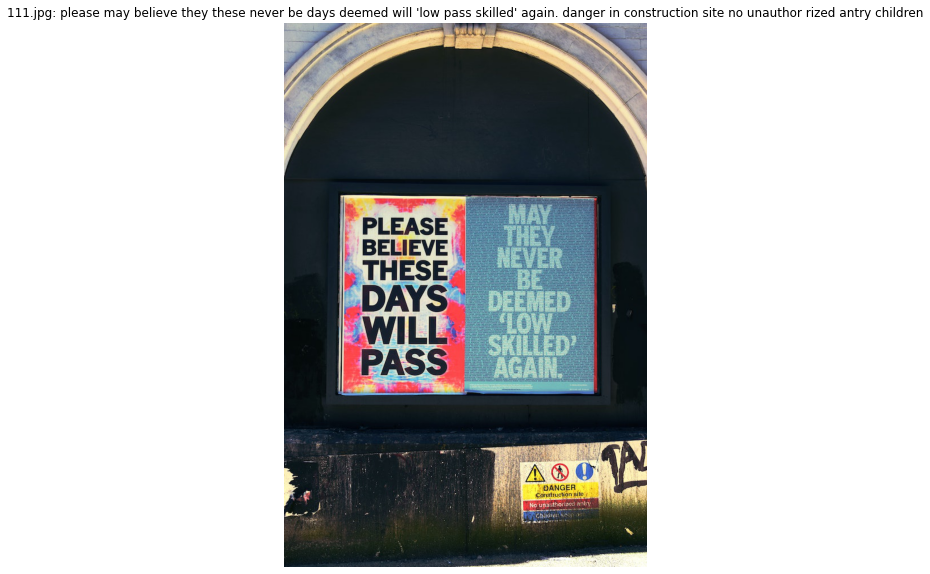

In [ ]:
task3_answer = '111.jpg'
plot_image(task3_answer, image_title=results_df.loc[task3_answer, 'text_in_image'])

##################################################################################################################
### SUBMISSION (DON'T CHANGE THE CODE)
Run the following cell which turns one row of the "results_df" corresponding to your answer into json and uploads it to S3. <font color='red'> **DON'T CHANGE THIS LINE** </font>. Just run it as it is once you have your answer in 'task3_answer'. This is your submission for Task #3. You'll receive credit shortly if you answer is correct.
##################################################################################################################

In [ ]:
# DON'T CHANGE THIS LINE OR YOUR SUBMISSION FAILS
submit_your_answer(results_df, 'task3_res.json', task3_answer)

## <font color='8B008B'> Task 4: Another unique identifier feature as seen above on the National Mall or Lincoln Memorial, also on statues or images by the entrance of companies can be faces </font>

Privacy policies differ for images containing faces of people. 
But unfortunately, AnyCorp information may not be available for every image.

### Your Task
Leverage Amazon 
 Rekognition 'detect_faces' API 
 to quickly count number of faces in each 
 image! More about the 'detect_faces' API:

https://docs.aws.amazon.com/rekognition/latest/dg/API_DetectFaces.html

Amazon Rekognition API 'detect_faces' reference:

https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/rekognition.html#Rekognition.Client.detect_faces

### Step #1:
Complete "extract_num_faces" function

### Step #2:
Run the "extract_num_faces" function on the text of all images. 

### Step #3: 
Find the image with containing four faces and submit your response.

### Task 4 Step 1- Count Number of Faces:
Complete "extract_num_faces" function: This function uses Amazon Rekognition "detect_faces" API to extract faces from an image. Once you have response from "detect_faces" API, count number of items in the "FaceDetails" key. The function should return the number of faces in an image. The portion of the function you write shouldn't be more than a few lines of code.

In [ ]:
def extract_num_faces(bucket_name, image_key):
    '''Extracts number of faces in the image using Amazon Rekognition 
       Arguments:
           bucketName (str): Name of the S3 bucket containing images
           image_key (str): object key of the image
       Output:
           n_faces (int): number of faces detected in the image       
    '''
    ### Your code (less than 5 lines of code)
    # Call the API first
    
    
    client=boto3.client('rekognition')

    response = client.detect_faces(Image={'S3Object':{'Bucket':BUCKET_NAME,'Name':image_key}},Attributes=['ALL'])

    return len(response['FaceDetails'])
    
    #n_faces = faces # Extract from API Response

    #return(n_faces)


Number of faces found: 3


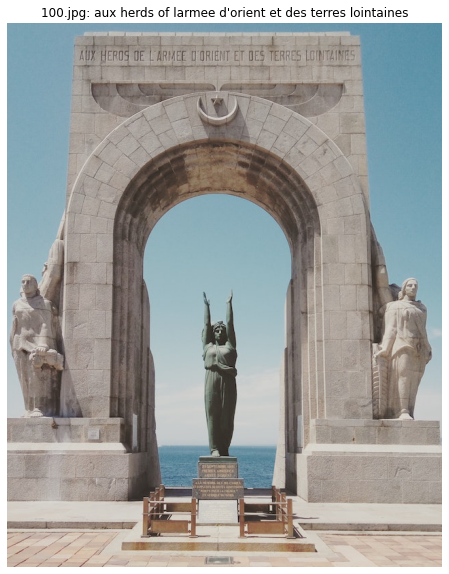

In [ ]:
## Sample test for your function
sample_image = '100.jpg'
n_faces = extract_num_faces(BUCKET_NAME, sample_image)
print('Number of faces found: {}'.format(n_faces))
plot_image(sample_image, image_title=results_df.loc[sample_image, 'text_in_image'])

## Task 4 Step 2: Populate 'n_face' column of the dataframe
Let's run the "extract_num_faces" function on the text of all images. It is going to extract number of faces on all images and fill the 'n_faces' columns. You don't need to do anything (no coding) other than running the code block under Task 4 Step 2 subsection. Please makes sure the "extract_num_faces" function in Step #1 works as expected before running this step. After it is done, take a look at "results_df" dataframe to make sure the 'n_faces' is populated. Other columns should be empty at this point. 


In [ ]:
for i, (key, row) in enumerate(results_df.iterrows()):
    print('processing image: {}'.format(key))

    # Extract text from results_df
    text_in_image = row['text_in_image']
    try: 
        n_faces = extract_num_faces(BUCKET_NAME, key)
        results_df.loc[key, 'n_faces'] = n_faces
    except Exception as e:
        print(e)
        print('Face extraction analysis failed')
        pass

processing image: 100.jpg
processing image: 101.jpg
processing image: 102.jpg
processing image: 103.jpg
processing image: 104.jpg
processing image: 105.jpg
processing image: 106.jpg
processing image: 107.jpg
processing image: 108.jpg
processing image: 109.jpg
processing image: 110.jpg
processing image: 111.jpg
processing image: 112.jpg
processing image: 117.jpg
processing image: 118.jpg
processing image: 119.jpg
processing image: 122.jpg
processing image: 123.jpg
processing image: 124.jpg
processing image: 125.jpg
processing image: 126.jpg
processing image: 127.jpg
processing image: 128.jpg
processing image: 129.jpg
processing image: 130.jpg
processing image: 131.jpg
processing image: 132.jpg
processing image: 133.jpg
processing image: 134.jpg
processing image: 135.jpg
processing image: 136.jpg
processing image: 137.jpg
processing image: 138.jpg
processing image: 139.jpg
processing image: 141.jpg
processing image: 143.jpg
processing image: 144.jpg
processing image: 145.jpg
processing i

In [ ]:
results_df.head()

bucket_name image_key  \
100.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   100.jpg   
101.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   101.jpg   
102.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   102.jpg   
103.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   103.jpg   
104.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   104.jpg   

                                             text_in_image  \
100.jpg  aux herds of larmee d'orient et des terres loi...   
101.jpg                                               home   
102.jpg                                  you are beautiful   
103.jpg                    all are welcome here. consentle   
104.jpg  @@@@@@@@@@? work hard stay humble $ m w 1 f no...   

        dominant_language_code dominant_language_score sentiment  \
100.jpg                     fr                    0.51   NEUTRAL   
101.jpg                     en                       1   NEUTRAL   
102.jpg                     en                       1  POSITIVE   
103.jpg                     en                       1   NEUTRAL   
104.jpg                     en                    0.86   NEUTRAL   

        sentiment_positive_score sentiment_negative_score  \
100.jpg                        0                        0   
101.jpg                     0.01                     0.01   
102.jpg                     0.99                        0   
103.jpg                     0.35                     0.02   
104.jpg                     0.01                        0   

        sentiment_neutral_score sentiment_mixed_score n_faces label label_conf  
100.jpg                    0.99                     0       3   NaN        NaN  
101.jpg                    0.97                     0       1   NaN        NaN  
102.jpg                       0                     0       0   NaN        NaN  
103.jpg                     0.5                  0.13       0   NaN        NaN  
104.jpg                    0.99                     0       0   NaN        NaN

### Task 4 Step 3: Find the image with four faces! 
Based on the 'n_faces' column of the results_df, which image has four faces? You can use the provided code to sort the dataframe by 'n_faces' in descending order. You can then either use the 'index' or the 'image_key' column to extract the image file name. Once you find that image, populate "task4_answer" with the image file name. Your response should be a string in the form of 'xxx.jpg'. 

In [ ]:
results_df.sort_values(by=['n_faces'], ascending=False)

bucket_name image_key  \
143.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   143.jpg   
100.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   100.jpg   
165.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   165.jpg   
185.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   185.jpg   
101.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   101.jpg   
...                                                    ...       ...   
136.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   136.jpg   
135.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   135.jpg   
134.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   134.jpg   
133.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   133.jpg   
202.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   202.jpg   

                                             text_in_image  \
143.jpg                                                      
100.jpg  aux herds of larmee d'orient et des terres loi...   
165.jpg                                           leonardo   
185.jpg             this is a neighbourhood area watch are   
101.jpg                                               home   
...                                                    ...   
136.jpg     + 824-741 st 4 city of perth hay cirv of perth   
135.jpg                                     libeouse oht!!   
134.jpg                                             notruf   
133.jpg                                   do what you love   
202.jpg                 extinguisher fire do not block mo-   

        dominant_language_code dominant_language_score sentiment  \
143.jpg                     en                    0.99       NaN   
100.jpg                     fr                    0.51   NEUTRAL   
165.jpg                     en                    0.35   NEUTRAL   
185.jpg                     en                       1   NEUTRAL   
101.jpg                     en                       1   NEUTRAL   
...                        ...                     ...       ...   
136.jpg                     en                    0.94   NEUTRAL   
135.jpg                     en                    0.51   NEUTRAL   
134.jpg                     de                    0.74   NEUTRAL   
133.jpg                     en                    0.99  POSITIVE   
202.jpg                     en                    0.97  NEGATIVE   

        sentiment_positive_score sentiment_negative_score  \
143.jpg                      NaN                      NaN   
100.jpg                        0                        0   
165.jpg                     0.01                        0   
185.jpg                     0.04                     0.01   
101.jpg                     0.01                     0.01   
...                          ...                      ...   
136.jpg                        0                        0   
135.jpg                     0.35                     0.08   
134.jpg                     0.01                     0.03   
133.jpg                     0.86                     0.01   
202.jpg                     0.02                     0.73   

        sentiment_neutral_score sentiment_mixed_score n_faces label label_conf  
143.jpg                     NaN                   NaN       4   NaN        NaN  
100.jpg                    0.99                     0       3   NaN        NaN  
165.jpg                    0.99                     0       2   NaN        NaN  
185.jpg                    0.95                     0       1   NaN        NaN  
101.jpg                    0.97                     0       1   NaN        NaN  
...                         ...                   ...     ...   ...        ...  
136.jpg                       1                     0       0   NaN        NaN  
135.jpg                    0.45                  0.12       0   NaN        NaN  
134.jpg                    0.96                     0       0   NaN        NaN  
133.jpg                     0.1                  0.03       0   NaN        Na

Did you find the image with the famous site of the four faces? If yes, provide the 'task4_answer' variable below with the image name ('xxx.jpg'). Let's also plot to make sure this is the correct answer! This together with unique facial recognition can provide another method for certain companies or industries to determine which company it is and therewith the location as seen here by identifying Mount Rushmore.

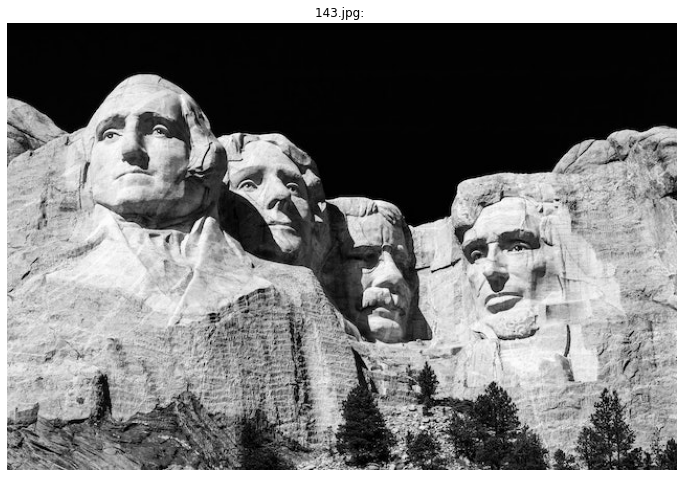

In [ ]:
task4_answer = '143.jpg'
plot_image(task4_answer, image_title='')

##################################################################################################################
### SUBMISSION (DON'T CHANGE THE CODE)
Run the following cell which turns one row of the "results_df" corresponding to your answer into json and uploads it to S3. <font color='red'> **DON'T CHANGE THIS LINE** </font>. Just run it as it is once you have your answer in 'task4_answer'.
##################################################################################################################

In [ ]:
# DON'T CHANGE THIS LINE OR YOUR SUBMISSION FAILS
submit_your_answer(results_df, 'task4_res.json', task4_answer)

## <font color='8B008B'> Task 5: More general object detection model without requiring faces through an automatic labeling or annotation of the images using Amazon Rekognition 'detect_labels' API, which can also be used as method for scaled training! </font>

Label all the images using Amazon Rekognition 
"detect_labels" API. This API analyses an 
image and returns labels along with their 
associated confidence score. More about the 
'detect_labels' API:

https://docs.aws.amazon.com/rekognition/latest/dg/labels-detect-labels-image.html

Amazon Rekognition API 'detect_labels' reference:

https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/rekognition.html#Rekognition.Client.detect_labels

### Step #1:
Complete 'extract_image_labels' function.


### Step #2:
Run the "extract_image_labels" function on the text of all images.

### Step #3: 
Find the image containing a 'bird' or 'animal' and submit the response.


### Task 5 Step 1- Find image labels:
Complete 'extract_image_labels' function: This function uses Amazon Rekognition 'detect_labels' API to extract labels from an image. Once you have response from 'detect_labels' API, extract top label and associated confidence score. The function should return these two values. The portion of the function you write shouldn't be more than a few lines of code. Examine the raw response from 'detect_labels' to understand how to extract top label and the associated confidence score.

In [ ]:
def extract_image_labels(bucket_name, image_key):
    '''Extracts number of faces in the image using Amazon Rekognition 
       Arguments:
           bucketName (str): Name of the S3 bucket containing images
           image_key (str): object key of the image
       Output:
           label (str): Label with highest score       
           label_conf (float): Label confidence score      
    '''
    ### Your code (less than 5 lines of code)
    # Call the API first
    
    client=boto3.client('rekognition')
    
    response = client.detect_labels(Image={'S3Object':{'Bucket':BUCKET_NAME,'Name':image_key}},
        MaxLabels=10)
    
    detected_text = response['Labels']
    label = detected_text[0]['Name']# Extract from API response
    label_conf = detected_text[0]['Confidence']# Extract from API response
        
    return(label, label_conf)

Automatically labeled as: ('Road Sign', 99.79357147216797)


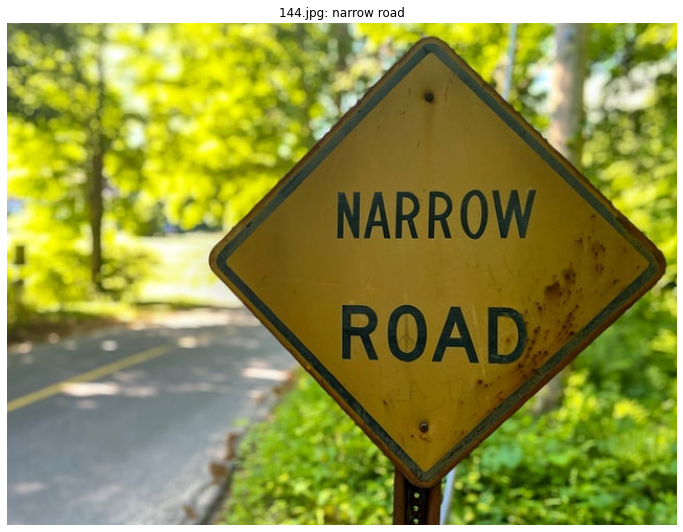

In [ ]:
## Sample test for your function
sample_image = '144.jpg'
label = extract_image_labels(BUCKET_NAME, sample_image)
print('Automatically labeled as: {}'.format(label))
plot_image(sample_image, image_title=results_df.loc[sample_image, 'text_in_image'])

## Task 5 Step 2: Populate 'label' and 'label_score' columns of the dataframe
Let's run the "extract_image_labels" function on the text of all images. It is going to extract label and confidence score on all images and fill the 'label' and 'label_conf' columns. You don't need to do anything (no coding) other than running the code block under Task 5 Step 2 subsection. Please makes sure the "extract_image_labels" function in Step #1 works as expected before running this step. After it is done, take a look at "results_df" dataframe to make sure the 'label' and 'label_conf' columns are populated. All columns should be populated at this point.

In [ ]:
for i, (key, row) in enumerate(results_df.iterrows()):
    print('processing image: {}'.format(key))

    try: 
        label, label_conf = extract_image_labels(BUCKET_NAME, key)
        results_df.loc[key, 'label'] = label
        results_df.loc[key, 'label_conf'] = label_conf
    except Exception as e:
        print(e)
        print('Unable to do label analysis')
        pass

processing image: 100.jpg
processing image: 101.jpg
processing image: 102.jpg
processing image: 103.jpg
processing image: 104.jpg
processing image: 105.jpg
processing image: 106.jpg
processing image: 107.jpg
processing image: 108.jpg
processing image: 109.jpg
processing image: 110.jpg
processing image: 111.jpg
processing image: 112.jpg
processing image: 117.jpg
processing image: 118.jpg
processing image: 119.jpg
processing image: 122.jpg
processing image: 123.jpg
processing image: 124.jpg
processing image: 125.jpg
processing image: 126.jpg
processing image: 127.jpg
processing image: 128.jpg
processing image: 129.jpg
processing image: 130.jpg
processing image: 131.jpg
processing image: 132.jpg
processing image: 133.jpg
processing image: 134.jpg
processing image: 135.jpg
processing image: 136.jpg
processing image: 137.jpg
processing image: 138.jpg
processing image: 139.jpg
processing image: 141.jpg
processing image: 143.jpg
processing image: 144.jpg
processing image: 145.jpg
processing i

In [ ]:
results_df.head()

bucket_name image_key  \
100.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   100.jpg   
101.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   101.jpg   
102.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   102.jpg   
103.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   103.jpg   
104.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   104.jpg   

                                             text_in_image  \
100.jpg  aux herds of larmee d'orient et des terres loi...   
101.jpg                                               home   
102.jpg                                  you are beautiful   
103.jpg                    all are welcome here. consentle   
104.jpg  @@@@@@@@@@? work hard stay humble $ m w 1 f no...   

        dominant_language_code dominant_language_score sentiment  \
100.jpg                     fr                    0.51   NEUTRAL   
101.jpg                     en                       1   NEUTRAL   
102.jpg                     en                       1  POSITIVE   
103.jpg                     en                       1   NEUTRAL   
104.jpg                     en                    0.86   NEUTRAL   

        sentiment_positive_score sentiment_negative_score  \
100.jpg                        0                        0   
101.jpg                     0.01                     0.01   
102.jpg                     0.99                        0   
103.jpg                     0.35                     0.02   
104.jpg                     0.01                        0   

        sentiment_neutral_score sentiment_mixed_score n_faces     label  \
100.jpg                    0.99                     0       3  Monument   
101.jpg                    0.97                     0       1  Monument   
102.jpg                       0                     0       0     Label   
103.jpg                     0.5                  0.13       0     Label   
104.jpg                    0.99                     0       0      Text   

        label_conf  
100.jpg    99.9853  
101.jpg    99.6775  
102.jpg        100  
103.jpg        100  
104.jpg    99.9974

### Task 5 Step 3: Find the image containing a bird!
You should now find the image containing a bird! Based on the 'label' column of the results_df, which image is labeled as 'bird' or 'animal'? To help, code is provided to sort the results_df based on 'label'. You can then either use the 'index' or the 'image_key' column to extract the image file name. 

Run 'upload_answer_to_s3' line to upload you answer as json to S3. You are done! 

In [ ]:
results_df.sort_values(by=['label'])

bucket_name image_key  \
195.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   195.jpg   
141.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   141.jpg   
156.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   156.jpg   
136.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   136.jpg   
177.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   177.jpg   
...                                                    ...       ...   
130.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   130.jpg   
138.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   138.jpg   
150.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   150.jpg   
194.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   194.jpg   
179.jpg  labstack-prewarm-a8a62cc1-ebc3-4f9a-b5-readima...   179.jpg   

                                             text_in_image  \
195.jpg  covid-19 mask required please do not enter wit...   
141.jpg                                                  a   
156.jpg                            beware dangerous cliffs   
136.jpg     + 824-741 st 4 city of perth hay cirv of perth   
177.jpg                            templewood, avenue nw3.   
...                                                    ...   
130.jpg     to fabulous las vegas <motor nevada <<yelee. "   
138.jpg                                                      
150.jpg  autour chapelle de la mathieu creations bijoux...   
194.jpg                                 no smoking hoituad   
179.jpg                          life is good at the beach   

        dominant_language_code dominant_language_score sentiment  \
195.jpg                     en                    0.59   NEUTRAL   
141.jpg                     en                    0.89   NEUTRAL   
156.jpg                     en                    0.97  NEGATIVE   
136.jpg                     en                    0.94   NEUTRAL   
177.jpg                     en                    0.33   NEUTRAL   
...                        ...                     ...       ...   
130.jpg                     en                    0.88  POSITIVE   
138.jpg                     en                    0.99       NaN   
150.jpg                     fr                    0.76   NEUTRAL   
194.jpg                     gl                     0.4   NEUTRAL   
179.jpg                     en                       1  POSITIVE   

        sentiment_positive_score sentiment_negative_score  \
195.jpg                     0.01                     0.04   
141.jpg                     0.02                     0.02   
156.jpg                        0                     0.83   
136.jpg                        0                        0   
177.jpg                        0                        0   
...                          ...                      ...   
130.jpg                     0.76                     0.01   
138.jpg                      NaN                      NaN   
150.jpg                        0                        0   
194.jpg                     0.05                     0.07   
179.jpg                     0.94                     0.01   

        sentiment_neutral_score sentiment_mixed_score n_faces          label  \
195.jpg                    0.95                     0       0  Advertisement   
141.jpg                    0.92                  0.03       0   Architecture   
156.jpg                    0.16                     0       0           Bird   
136.jpg                       1                     0       0          Brick   
177.jpg                       1                     0       0          Brick   
...                         ...                   ...     ...            ...   
130.jpg                     0.2                  0.03       0           Tree   
138.jpg                     NaN                   NaN       0          Villa   
150.jpg                       1                     0       0        Walkway   
194.jpg                    0.87                  0.01       0          Wheel   
179.jpg

Did you find the image with the label 'bird' or 'animal'? If yes, provide the 'task5_answer' variable below with the image name ('xxx.jpg'). Let's also plot to make sure this is the correct answer!

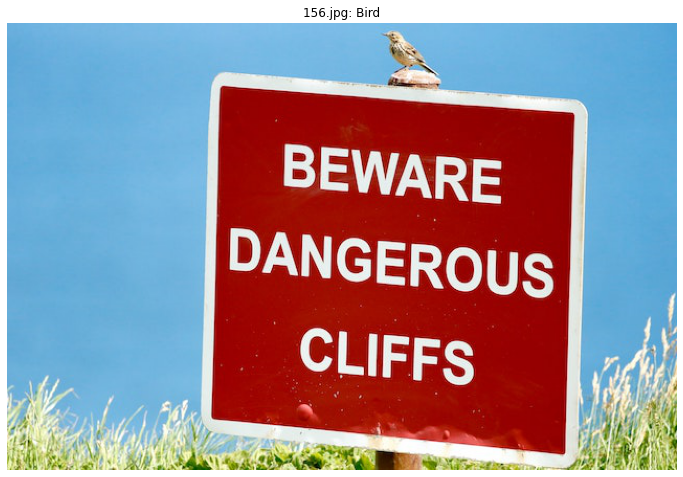

In [ ]:
task5_answer = '156.jpg'
plot_image(task5_answer, image_title=results_df.loc[task5_answer, 'label'])

##################################################################################################################
### SUBMISSION (DON'T CHANGE THE CODE)
Run the following cell which turns one row of the "results_df" corresponding to your answer into json and uploads it to S3. <font color='red'> **DON'T CHANGE THIS LINE** </font>. Just run it as it is once you have your answer in 'task5_answer'. 
##################################################################################################################

In [ ]:
# DON'T CHANGE THIS LINE OR YOUR SUBMISSION FAILS
submit_your_answer(results_df, 'task5_res.json', task5_answer)

## Congratulations! 